In [1]:
import pitchfork.pitchfork as pitchfork
from pitchfork.pitchfork.pitchfork import Review # For restoring saved reviews
from bs4 import BeautifulSoup
import json
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time

# Load and format the artist lyrics

In [2]:
# Load the lyrics
artists_rap = json.load(open('lyrics/rap_lyrics.json'))
artists_rock = json.load(open('lyrics/rock_lyrics.json'))
artists_country = json.load(open('lyrics/country_lyrics.json'))
artists_raw = artists_rap + artists_rock + artists_country

In [3]:
# Determine
def getArtistImage(songs):    
    urls = [None]
    for song in songs:
        if song['raw']['album'] is not None:
            try:                
                urls.append(song['raw']['album']['artist']['image_url'])                
            except:
                pass
    
    return Counter(urls).most_common()[0][0] # Most common image

# Use a generator to exclude artists with too few songs
def filterBySongCount(artists, min_count=10, max_count=10000):
    for artist in artists:        
        num_songs = len(artist['songs'])
        if (num_songs >= min_count) and (num_songs < max_count): yield artist

min_songs, max_songs = 10, 2500
artists = list(filterBySongCount(artists_raw, min_songs, max_songs))

# Artist images
for artist in artists:
    artist['image_url'] = getArtistImage(artist['songs'])
    
    # Kludge
    if artist['artist'] == 'Black Thought':
        artist['image_url'] = 'https://images.genius.com/23de511f4ac50d900128ea363b7d81b3.450x320x1.jpg'
    if artist['artist'] == 'André 3000':
        artist['image_url'] = 'http://images.genius.com/64b15c9489c65f5bf8f6577334347404.434x434x1.jpg'            
        
# Gender
labels_gender = np.array([a['gender'] for a in artists])
mask_female = np.array([g=='female' for g in labels_gender])
mask_male   = np.array([g=='male'   for g in labels_gender])
print("You have lyrics from {} artists, with a minimum of {} songs per artist.\nFemale: {}, male: {}"
      .format(len(artists), min_songs, (labels_gender=='female').sum(), (labels_gender=='male').sum()))

# Add all song lyrics to a single list
all_songs = []
for artist, gender in zip(artists, labels_gender):
    for song in artist['songs']:        
        song['gender'] = gender
        all_songs.append(song)
              
song_count = len(all_songs)
print("Database contains {} songs.".format(song_count))

# Store all lyrics in a single string
all_lyrics = " ".join([song['lyrics'] for song in all_songs])

You have lyrics from 303 artists, with a minimum of 10 songs per artist.
Female: 79, male: 222
Database contains 58239 songs.


# Load the Pitchfork album reviews

In [115]:
filename_album_reviews = "./backups/album_reviews.pickle"
if os.path.exists(filename_album_reviews) and os.path.getsize(filename_album_reviews) > 0:
    artist_reviews = pickle.load(open(filename_album_reviews, 'rb'))    

## Convert the reviews from JSON string to Pitchfork Review format

In [116]:
def convert_json_to_review(review_as_string):
    json_obj = json.loads(review_as_string)
    return Review(json_obj['searched_artist'], json_obj['searched_album'],
                  json_obj['matched_artist'], json_obj['matched_album'],
                  json_obj['query'], json_obj['url'], BeautifulSoup(json_obj['soup'], "lxml"))

In [117]:
# Convert to Review format
all_reviews = {}
for name, albums in artist_reviews.items():
    print(name)
    album_reviews = []
    for album, review in albums.items():
        album_reviews.append(convert_json_to_review(review))
    all_reviews[name] = album_reviews
print('\nDone.')

Kanye West
The Beatles
2Pac
Eminem
The Notorious B.I.G.
Nas
Ice Cube
JAY-Z
Snoop Dogg
Dr. Dre
Kendrick Lamar
A$AP Rocky
50 Cent
Busta Rhymes
J. Cole
Method Man
KRS-One
Ludacris
Lil Wayne
Common
Ghostface Killah
T.I.
Lauryn Hill
Scarface
Raekwon
The Game
Ol' Dirty Bastard
Mobb Deep
Logic
Chance The Rapper
Cypress Hill
Lupe Fiasco
RZA
GZA
Warren G
Q-Tip
Talib Kweli
Missy Elliott
Immortal Technique
Big Sean
Kid Cudi
Twista
Big Boi
Drake
Wiz Khalifa
Eric B. & Rakim
ScHoolboy Q
Run-D.M.C.
Hopsin
Nelly
Tyler, The Creator
Jadakiss
Kurupt
Grandmaster Flash & The Furious Five
N.W.A
Gang Starr
E-40
Pusha T
De La Soul
Yelawolf
Earl Sweatshirt
Fabolous
Mac Miller
Jeezy
Kodak Black
2 Chainz
Chief Keef
Gucci Mane
Salt-N-Pepa
Lil' Kim
Nicki Minaj
M.I.A.
Azealia Banks
Angel Haze
DeJ Loaf
Jean Grae
Ciara
Estelle
Tink
The Kinks
The Beach Boys
Bruce Springsteen
Alice in Chains
ZZ Top
Green Day
Neil Young
Tom Petty and the Heartbreakers
Foo Fighters
Grateful Dead
Rush
Red Hot Chili Peppers
Michael Jackson

## Extract and store data from the Pitchfork reviews

In [134]:
scores, years = [], []
male_scores, female_scores = [],[]
for artist in artists:
    name = artist['artist']
    if name in all_reviews:
        # Collect information from the review        
        for r in all_reviews[name]:
            year = r.year().split('/')[0] # Album year
            score = r.score() # Review score
            if year != "":
                years.append(int(year))  # Album year
                scores.append(score) # Review score

                # Store scores by gender        
                if artist['gender'] == 'male':
                    male_scores.append(score)
                elif artist['gender'] == 'female':
                    female_scores.append(score)
            
# Group together scores into single list
scores_by_gender = [male_scores, female_scores]

## Pitchfork reviews over time

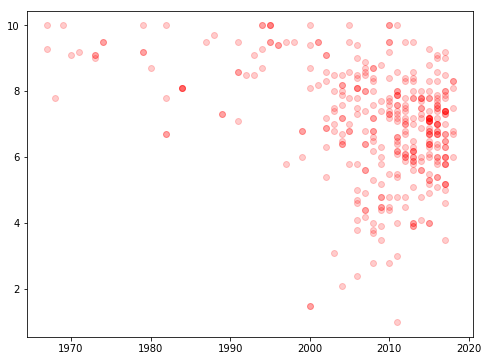

In [135]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(years, scores, 'ro', alpha=0.2)
plt.show()

## Pitchfork review scores separated by gender

In [147]:
help(ax.boxplot)

Help on method boxplot in module matplotlib.axes._axes:

boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None, meanprops=None, capprops=None, whiskerprops=None, manage_xticks=True, autorange=False, zorder=None, *, data=None) method of matplotlib.axes._subplots.AxesSubplot instance
    Make a box and whisker plot.
    
    Make a box and whisker plot for each column of ``x`` or each
    vector in sequence ``x``.  The box extends from the lower to
    upper quartile values of the data, with a line at the median.
    The whiskers extend from the box to show the range of the
    data.  Flier points are those past the end of the whiskers.
    
    Parameters
    ----------
    x : Array or a sequence of vectors.
        The input data.
    
    notch 

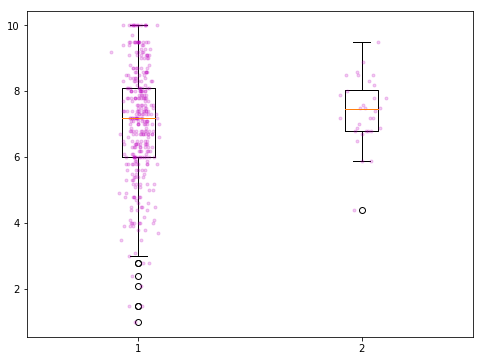

In [146]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(scores_by_gender)
for i,y in enumerate(scores_by_gender):
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'm.', alpha=0.2)
plt.show()

## Interactive plot that shows review abstract with mouse over